## [Detecting Trend Shifts Using Adaptive Wave Bands](https://medium.com/@crisvelasquez/detecting-trend-shifts-using-adaptive-wave-bands-dfc10c9d2742)

> A Volatility-Aware Count-Based System That Visualizes Real-time Trend Flips, Directional Strength, and Trend Persistence

**TrendWave** Bands don't try to predict market direction. They, instead, react to it cleanly, visually, and in real time.

TrendWave Bands combine smoothed price levels with dynamic volatility buffers to identify trend transitions.

Unlike fixed-width envelopes, these bands adapt in real time to changing market conditions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q pandas numpy matplotlib yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use("dark_background")

# USER PARAMETERS
TICKER     = "ASML.AS"        # Ticker symbol used to pull data from Yahoo Finance
START_DATE = "2023-01-01"     # Start date for historical data
END_DATE   = "2026-06-01"     # End date for historical data

LENGTH     = 50               # Lookback window used to smooth signals and compute trend structure
FACTOR     = 1.0              # Multiplier for volatility band width; higher => wider bands

COLOR_UP   = "#00FF00"        # Line color when trend is up
COLOR_DN   = "#DD1A1A"        # Line color when trend is down
COLOR_UL   = "#00FFFF"        # Color used for wave extensions (ATR-based bands)

SHOW_BANDS      = True        # Toggle to draw the trend-following bands
GRADIENT        = True        # If True, use opacity gradient in the fill for visual emphasis
SHOW_DASHBOARD  = True        # If True, print config and trend summary in the console

In [4]:
# Data Download & Preprocessing

# Download daily data
df = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", auto_adjust=False)
if df.empty:
    print("No data returned for the given ticker/date range.")
    exit(1)

# Flatten multi-index columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.map("_".join)

# Robust column renaming:
# Expected keys for price data.
keys = ["Open", "High", "Low", "Close", "Volume", "Adj Close"]
rename_dict = {}
for key in keys:
    if key not in df.columns:
        # Search for any column that starts with the key
        for col in df.columns:
            if col.startswith(key):
                rename_dict[col] = key
                print(f"Column '{col}' found. Renaming it to '{key}'.")
                break
if rename_dict:
    df.rename(columns=rename_dict, inplace=True)

# Verify required columns exist now.
for key in ["High", "Low", "Close"]:
    if key not in df.columns:
        print(f"Required column '{key}' not found after renaming. Available columns: {df.columns}")
        exit(1)

df.dropna(inplace=True)
if df.empty:
    print("Data is empty after cleaning. Exiting.")
    exit()

# Standardize column names for later use.
df["Price"] = df["Close"]
df["Time"]  = df.index

# Convert the date index to a NumPy array (for positional indexing).
dates_arr = df.index.to_numpy()

print("Dates Count: ", len(dates_arr))

df.head()

[*********************100%***********************]  1 of 1 completed

Column 'Open_ASML.AS' found. Renaming it to 'Open'.
Column 'High_ASML.AS' found. Renaming it to 'High'.
Column 'Low_ASML.AS' found. Renaming it to 'Low'.
Column 'Close_ASML.AS' found. Renaming it to 'Close'.
Column 'Volume_ASML.AS' found. Renaming it to 'Volume'.
Column 'Adj Close_ASML.AS' found. Renaming it to 'Adj Close'.
Dates Count:  643


,Adj Close,Close,High,Low,Open,Volume,Price,Time
Date,,,,,,,,
2023-01-02,505.012054,516.900024,517.299988,509.200012,515.000000,399536,516.900024,2023-01-02
2023-01-03,508.333832,520.299988,536.400024,517.599976,522.000000,711724,520.299988,2023-01-03
2023-01-04,524.649780,537.000000,542.500000,519.700012,526.000000,846525,537.000000,2023-01-04
2023-01-05,527.483032,539.900024,544.200012,533.299988,537.099976,533572,539.900024,2023-01-05
2023-01-06,538.816284,551.500000,554.000000,532.400024,538.000000,555958,551.500000,2023-01-06


In [5]:
# Compute TrendWave Bands & Trend Flip Markers

# Compute typical price as hlc3: (High + Low + Close) / 3.
df["hlc3"] = (df["High"] + df["Low"] + df["Close"]) / 3.0

# --- Define helper functions used here ---
def sma(series, period):
    """Simple moving average."""
    return series.rolling(window=period, min_periods=1).mean()

def highest(series, length):
    """Rolling maximum over the specified length."""
    return series.rolling(window=int(length), min_periods=1).max()

def lowest(series, length):
    """Rolling minimum over the specified length."""
    return series.rolling(window=int(length), min_periods=1).min()

def atr(df, length=14):
    """
    Average True Range calculation.
    $$ATR = SMA( TR, length)$$
    where $$TR = max(High-Low, |High-prevClose|, |Low-prevClose|)$$
    """
    high = df["High"]
    low  = df["Low"]
    prev_close = df["Close"].shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(window=length, min_periods=1).mean()

In [6]:
# Precompute rolling metrics.
df["volatility"] = sma(df["High"] - df["Low"], 70) * FACTOR
df["sma_25"]     = sma(df["Close"], 25)
df["sma_len"]    = sma(df["Close"], LENGTH)
df["upper_raw"]  = highest(df["sma_25"] + df["volatility"], LENGTH/2)
df["lower_raw"]  = lowest(df["sma_len"] - df["volatility"], LENGTH/2)
df["ATR100"]     = atr(df, 100)

# Initialize arrays for trend determination.
n = len(df)
upper = np.full(n, np.nan)
lower = np.full(n, np.nan)
direction = np.zeros(n, dtype=int)
count_up  = np.zeros(n, dtype=float)
count_dn  = np.zeros(n, dtype=float)

# Convert relevant columns to arrays.
hlc3_arr      = df["hlc3"].values
upper_raw_arr = df["upper_raw"].values
lower_raw_arr = df["lower_raw"].values

# --- Define crossover and crossunder helpers ---
def crossover(prevA, A, prevB, B):
    """Returns True if A crosses over B."""
    return (prevA < prevB) and (A >= B)

def crossunder(prevA, A, prevB, B):
    """Returns True if A crosses under B."""
    return (prevA > prevB) and (A <= B)

# Loop over bars to determine trend direction and count consecutive moves.
for i in range(n):
    if i == 0:
        direction[i] = 0
        continue

    sig_up = crossover(hlc3_arr[i-1], hlc3_arr[i], upper_raw_arr[i-1], upper_raw_arr[i])
    sig_dn = crossunder(hlc3_arr[i-1], hlc3_arr[i], lower_raw_arr[i-1], lower_raw_arr[i])

    if sig_up:
        direction[i] = 1
    elif sig_dn:
        direction[i] = -1
    else:
        direction[i] = direction[i-1]

    if direction[i] == 1:
        upper[i] = np.nan
        lower[i] = lower_raw_arr[i]
    elif direction[i] == -1:
        upper[i] = upper_raw_arr[i]
        lower[i] = np.nan
    else:
        upper[i] = np.nan
        lower[i] = np.nan

    if direction[i] == 1:
        count_up[i] = count_up[i-1] + 0.5
        count_dn[i] = 0
    elif direction[i] == -1:
        count_dn[i] = count_dn[i-1] + 0.5
        count_up[i] = 0
    else:
        count_up[i] = count_up[i-1]
        count_dn[i] = count_dn[i-1]

    if count_up[i] > 70:  count_up[i] = 70
    if count_dn[i] > 70:  count_dn[i] = 70

df["direction"] = direction
df["upper"]     = upper
df["lower"]     = lower
df["count_up"]  = count_up
df["count_dn"]  = count_dn

# Compute wave lines based on ATR offset.
df["upper_band"] = df["lower"] + df["ATR100"] * 5
df["lower_band"] = df["upper"] - df["ATR100"] * 5

# Compute trend flip markers (for plotting) by detecting when the direction changes.
flip_up_x = []
flip_up_y = []
flip_dn_x = []
flip_dn_y = []
dir_arr = df["direction"].values
for i in range(1, n):
    if dir_arr[i] != dir_arr[i-1]:
        if dir_arr[i] == 1:
            flip_up_x.append(dates_arr[i])
            flip_up_y.append(lower[i])
        elif dir_arr[i] == -1:
            flip_dn_x.append(dates_arr[i])
            flip_dn_y.append(upper[i])

In [7]:
df.head()

,Adj Close,Close,High,Low,Open,Volume,Price,Time,hlc3,volatility,...,upper_raw,lower_raw,ATR100,direction,upper,lower,count_up,count_dn,upper_band,lower_band
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,505.012054,516.900024,517.299988,509.200012,515.000000,399536,516.900024,2023-01-02,514.466675,8.099976,...,525.000000,508.800049,8.099976,0,NaN,NaN,0.0,0.0,NaN,NaN
2023-01-03,508.333832,520.299988,536.400024,517.599976,522.000000,711724,520.299988,2023-01-03,524.766663,13.450012,...,532.050018,505.149994,13.799988,0,NaN,NaN,0.0,0.0,NaN,NaN
2023-01-04,524.649780,537.000000,542.500000,519.700012,526.000000,846525,537.000000,2023-01-04,533.066671,16.566671,...,541.300008,505.149994,16.799988,0,NaN,NaN,0.0,0.0,NaN,NaN
2023-01-05,527.483032,539.900024,544.200012,533.299988,537.099976,533572,539.900024,2023-01-05,539.133341,15.150009,...,543.675018,505.149994,15.324997,0,NaN,NaN,0.0,0.0,NaN,NaN
2023-01-06,538.816284,551.500000,554.000000,532.400024,538.000000,555958,551.500000,2023-01-06,545.966675,16.440002,...,549.560010,505.149994,16.579993,0,NaN,NaN,0.0,0.0,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 643 entries, 2023-01-02 to 2025-07-10
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Adj Close   643 non-null    float64       
 1   Close       643 non-null    float64       
 2   High        643 non-null    float64       
 3   Low         643 non-null    float64       
 4   Open        643 non-null    float64       
 5   Volume      643 non-null    int64         
 6   Price       643 non-null    float64       
 7   Time        643 non-null    datetime64[ns]
 8   hlc3        643 non-null    float64       
 9   volatility  643 non-null    float64       
 10  sma_25      643 non-null    float64       
 11  sma_len     643 non-null    float64       
 12  upper_raw   643 non-null    float64       
 13  lower_raw   643 non-null    float64       
 14  ATR100      643 non-null    float64       
 15  direction   643 non-null    int64         
 16  upper  

In [9]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume,Price,Time,hlc3,volatility,...,upper_raw,lower_raw,ATR100,direction,upper,lower,count_up,count_dn,upper_band,lower_band
count,643.000000,643.000000,643.000000,643.000000,643.000000,6.430000e+02,643.000000,643,643.000000,643.000000,...,643.000000,643.000000,643.000000,643.000000,290.000000,348.000000,643.000000,643.000000,348.000000,290.000000
mean,689.706452,697.259564,706.268974,688.303964,697.783515,6.478204e+05,697.259564,2024-04-04 04:04:06.345256704,697.277501,17.940327,...,736.288006,654.004189,20.080534,0.090202,753.591890,630.127852,10.097978,8.163297,723.643479,644.411014
min,505.012054,516.900024,517.299988,508.399994,515.000000,1.165310e+05,516.900024,2023-01-02 00:00:00,514.466675,8.099976,...,525.000000,505.149994,8.099976,-1.000000,594.091719,505.149994,0.000000,0.000000,589.016652,512.741707
25%,604.406342,613.849976,621.200012,605.700012,613.650024,4.551570e+05,613.849976,2023-08-17 12:00:00,614.516663,14.540004,...,637.121432,579.202991,16.043502,-1.000000,634.595002,573.171785,0.000000,0.000000,653.082211,554.160820
50%,659.000000,664.500000,672.099976,657.000000,664.700012,5.728450e+05,664.500000,2024-04-05 00:00:00,663.666646,17.760004,...,688.192000,621.743425,18.610006,1.000000,727.039998,603.463426,2.500000,0.000000,705.131221,609.708276
75%,751.714722,757.450012,770.349976,745.950012,764.000000,7.410055e+05,757.450012,2024-11-18 12:00:00,759.216665,20.510716,...,826.650142,697.734565,23.065000,1.000000,838.332640,643.618431,16.000000,13.500000,755.760603,700.355123
max,992.768982,1002.200012,1021.799988,993.000000,1010.400024,2.713321e+06,1002.200012,2025-07-10 00:00:00,1000.566671,27.955003,...,996.773003,886.786571,29.626502,1.000000,996.773003,857.092429,61.500000,53.500000,978.954941,873.425494
std,114.417812,114.440920,116.242847,113.422840,115.343763,3.182448e+05,114.440920,NaN,114.576077,4.046131,...,121.340512,102.495663,4.461713,0.992784,125.835509,92.431724,14.487605,12.710003,102.390785,109.213909


In [10]:
# Build Final Arrays for Plotting
# Convert required series to arrays.
dates_arr = df.index.to_numpy()
price_arr = df["Price"].values
upper_arr = df["upper"].values
lower_arr = df["lower"].values
upper_band_arr = df["upper_band"].values
lower_band_arr = df["lower_band"].values

# --- Define helper functions for plotting arrays ---
def hex_with_alpha(hexcolor, alpha):
    """Convert a hex color (e.g., '#FF0000') and alpha (0..1) into an RGBA tuple."""
    import matplotlib.colors as mcolors
    base = mcolors.to_rgba(hexcolor)
    return (base[0], base[1], base[2], alpha)

def alpha_from_count(c):
    """Convert a count (0..70) to an alpha value (0..1)."""
    return min(float(c) / 70.0, 1.0)

def build_line_arrays(base_arr, count_arr, color_main):
    """
    Build arrays for the main line:
      - Use the base array for y-values.
      - Skip every other bar to create a "line break" effect.
      - Adjust the color alpha based on the count.
    """
    line_x = dates_arr.copy()
    line_y = base_arr.copy()
    line_c = np.zeros((n, 4))
    for i in range(n):
        if i % 2 == 0:
            line_y[i] = np.nan
        a = alpha_from_count(count_arr[i])
        line_c[i] = hex_with_alpha(color_main, a)
    return line_x, line_y, line_c

def build_wave_arrays(band_arr, count_arr):
    """
    Build arrays for wave lines:
      - Use the band array for y-values, skipping every other bar.
      - Invert alpha so that a higher count gives a lower alpha.
    """
    line_x = dates_arr.copy()
    line_y = band_arr.copy()
    line_c = np.zeros((n, 4))
    for i in range(n):
        if i % 2 == 0:
            line_y[i] = np.nan
        a = alpha_from_count(count_arr[i])
        wave_alpha = 1.0 - a
        line_c[i] = hex_with_alpha(COLOR_UL, wave_alpha)
    return line_x, line_y, line_c

def build_shadow_arrays(base_arr, count_arr, color_main):
    """
    Build shadow arrays with doubled alpha (capped at 1.0) for a shadow effect.
    """
    line_x = dates_arr.copy()
    line_y = base_arr.copy()
    line_c = np.zeros((n, 4))
    for i in range(n):
        if i % 2 == 0:
            line_y[i] = np.nan
        a = alpha_from_count(count_arr[i])
        shadow_a = min(a * 2, 1.0)
        line_c[i] = hex_with_alpha(color_main, shadow_a)
    return line_x, line_y, line_c

In [11]:
# Build arrays for main upper/lower lines.
upper_line_x, upper_line_y, upper_line_c = build_line_arrays(upper_arr, df["count_dn"].values, COLOR_DN)
lower_line_x, lower_line_y, lower_line_c = build_line_arrays(lower_arr, df["count_up"].values, COLOR_UP)

# Build arrays for wave lines (offset bands).
upper_wave_x, upper_wave_y, upper_wave_c = build_wave_arrays(upper_band_arr, df["count_up"].values)
lower_wave_x, lower_wave_y, lower_wave_c = build_wave_arrays(lower_band_arr, df["count_dn"].values)

# Build arrays for shadow lines.
upper_shadow_x, upper_shadow_y, upper_shadow_c = build_shadow_arrays(upper_arr, df["count_dn"].values, COLOR_DN)
lower_shadow_x, lower_shadow_y, lower_shadow_c = build_shadow_arrays(lower_arr, df["count_up"].values, COLOR_UP)

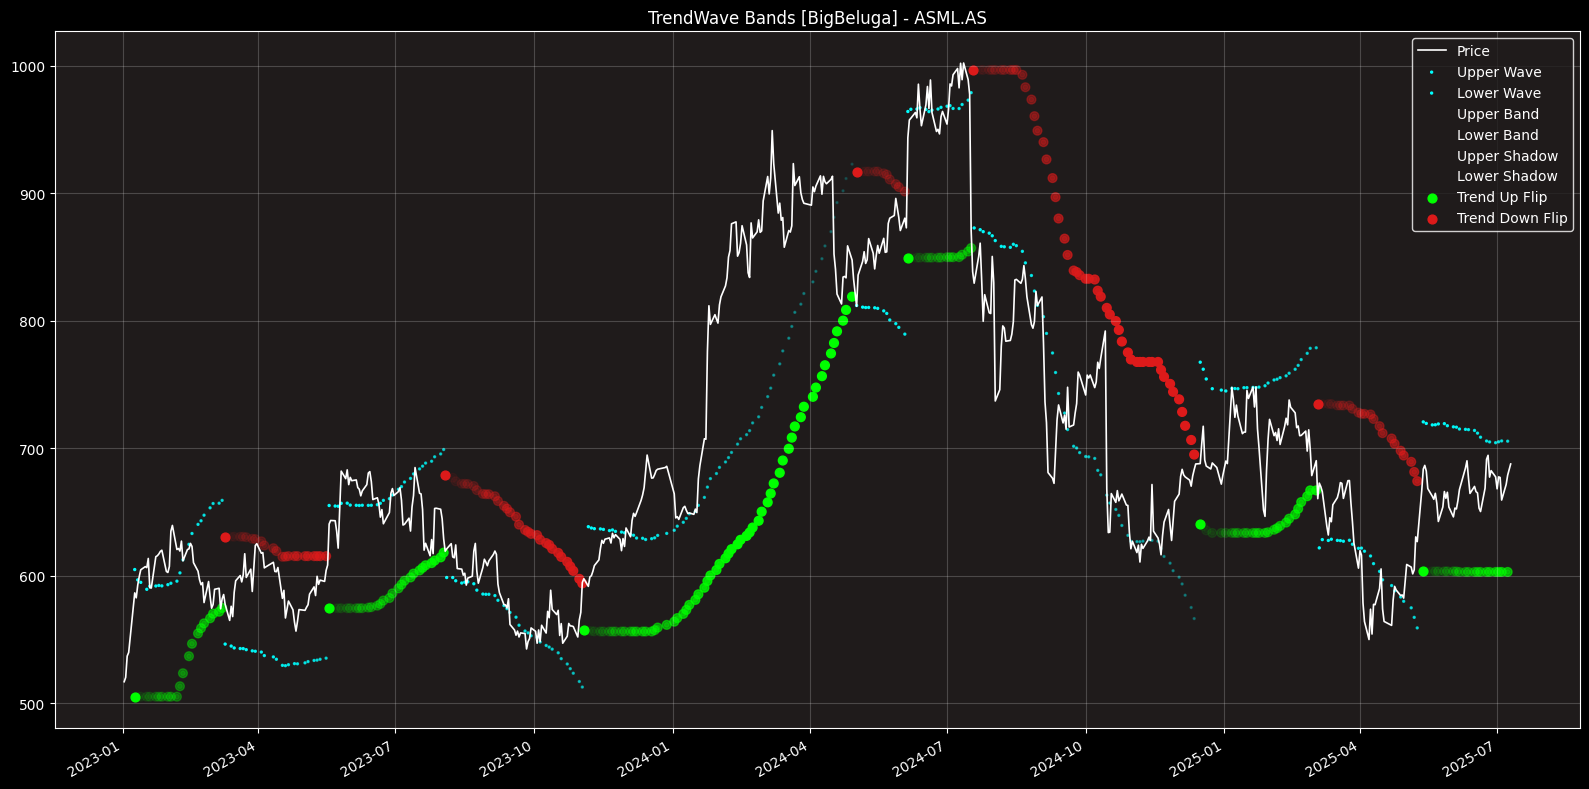

In [12]:
# Plotting
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor("#1F1B1B")
ax.grid(True, alpha=0.2)

ax.set_title(f"TrendWave Bands [BigBeluga] - {TICKER}", color="white")

# Plot the price in white.
ax.plot(dates_arr, price_arr, color="white", linewidth=1.2, label="Price")

# Plot wave lines using scatter with small markers.
ax.scatter(upper_wave_x, upper_wave_y, c=upper_wave_c, s=2, label="Upper Wave")
ax.scatter(lower_wave_x, lower_wave_y, c=lower_wave_c, s=2, label="Lower Wave")

# Plot main band lines.
ax.scatter(upper_line_x, upper_line_y, c=upper_line_c, s=10, label="Upper Band")
ax.scatter(lower_line_x, lower_line_y, c=lower_line_c, s=10, label="Lower Band")

# Plot shadow lines.
ax.scatter(upper_shadow_x, upper_shadow_y, c=upper_shadow_c, s=40, label="Upper Shadow")
ax.scatter(lower_shadow_x, lower_shadow_y, c=lower_shadow_c, s=40, label="Lower Shadow")

# Plot trend flip markers.
ax.scatter(flip_up_x, flip_up_y, marker="o", s=40, color=COLOR_UP, label="Trend Up Flip")
ax.scatter(flip_dn_x, flip_dn_y, marker="o", s=40, color=COLOR_DN, label="Trend Down Flip")

ax.legend(loc="best", facecolor="#1F1B1B", edgecolor="white")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()